In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv("AirPassengers.csv",index_col="Month",parse_dates=True)

In [3]:
df=data.copy()

In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.rename(columns={"#Passengers":"Passengers"},inplace=True)

In [6]:
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

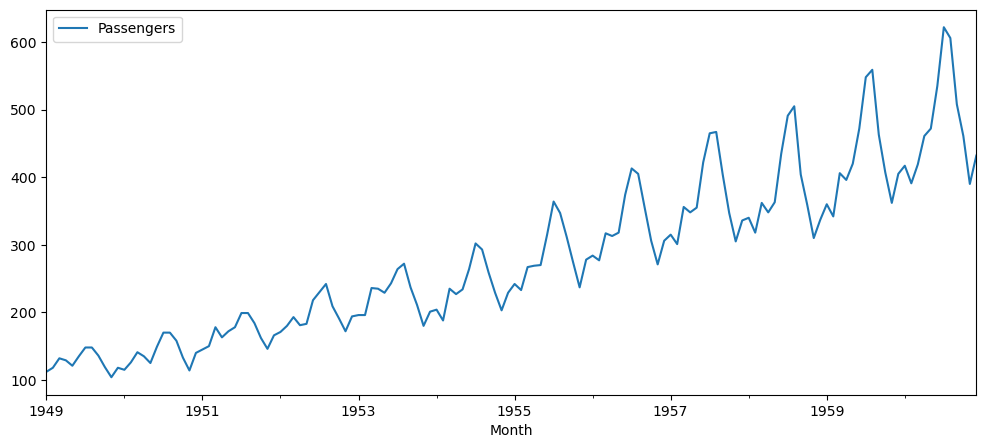

In [7]:
df.plot(figsize=(12,5))

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
df.index.freq="MS"

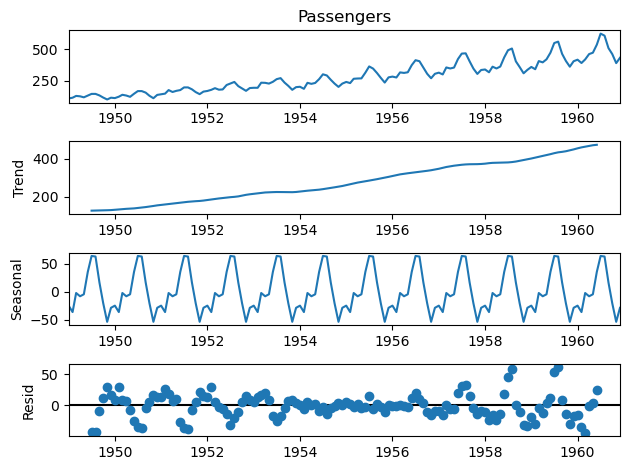

In [10]:
result=seasonal_decompose(df['Passengers'])
result.plot();

In [11]:
len(df)

144

In [12]:
train=df.iloc[:132]
test=df.iloc[132:]

In [13]:
train.shape

(132, 1)

In [14]:
test.shape

(12, 1)

In [15]:
train.iloc[0],train.iloc[-1]

(Passengers    112
 Name: 1949-01-01 00:00:00, dtype: int64,
 Passengers    405
 Name: 1959-12-01 00:00:00, dtype: int64)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler()

In [17]:
scalar.fit(train)
scaled_train=scalar.transform(train)
scaled_test=scalar.transform(test)

In [18]:
scaled_train[:10]

array([[0.01758242],
       [0.03076923],
       [0.06153846],
       [0.05494505],
       [0.03736264],
       [0.06813187],
       [0.0967033 ],
       [0.0967033 ],
       [0.07032967],
       [0.03296703]])

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
n_input=12
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [21]:
generator[0][0].shape

(1, 12, 1)

In [22]:
len(scaled_train),len(generator)

(132, 120)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [24]:
model=Sequential()
model.add(LSTM(1000,activation="relu",input_shape=(12,1)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4008000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 4009001 (15.29 MB)
Trainable params: 4009001 (15.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model.fit(generator,epochs=50)

Epoch 1/50

120/120 [==============================] - 28s 217ms/step - loss: 0.0212
Epoch 2/50
120/120 [==============================] - 26s 214ms/step - loss: 0.0157
Epoch 3/50
120/120 [==============================] - 26s 220ms/step - loss: 0.0149
Epoch 4/50
120/120 [==============================] - 28s 233ms/step - loss: 0.0090
Epoch 5/50
120/120 [==============================] - 26s 218ms/step - loss: 0.0089
Epoch 6/50
120/120 [==============================] - 26s 218ms/step - loss: 0.0051
Epoch 7/50
120/120 [==============================] - 26s 217ms/step - loss: 0.0053
Epoch 8/50
120/120 [==============================] - 26s 217ms/step - loss: 0.0035
Epoch 9/50
120/120 [==============================] - 26s 217ms/step - loss: 0.0034
Epoch 10/50
120/120 [==============================] - 26s 217ms/step - loss: 0.0046
Epoch 11/50
120/120 [==============================] - 26s 218ms/step - loss: 0.0021
Epoch 12/50
120/120 [==============================] - 26s 217ms/step - l

In [27]:
loss=model.history.history["loss"]

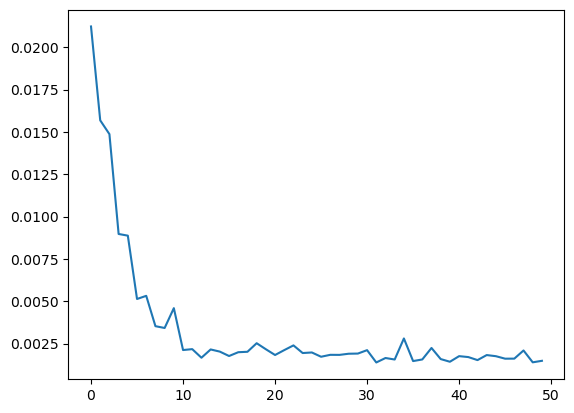

In [28]:
plt.plot(range(len(loss)),loss)

In [29]:
last_train_batch=scaled_train[-12:]


In [30]:
last_train_batch=last_train_batch.reshape((1,12,1))


In [31]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 355ms/step


array([[0.6459736]], dtype=float32)

In [32]:
scaled_test[0]

array([0.68791209])

In [33]:
test_predictions=[]
first_evel_batch=scaled_train[-12:]
current_batch=first_evel_batch.reshape((1,12,1))
for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 46ms/step


In [34]:
test_predictions

[array([0.6459736], dtype=float32),
 array([0.60766405], dtype=float32),
 array([0.7186001], dtype=float32),
 array([0.7298102], dtype=float32),
 array([0.7688968], dtype=float32),
 array([0.8797516], dtype=float32),
 array([1.076493], dtype=float32),
 array([1.1355813], dtype=float32),
 array([0.90407294], dtype=float32),
 array([0.73806554], dtype=float32),
 array([0.63805497], dtype=float32),
 array([0.70714206], dtype=float32)]

In [35]:
 test.head()

,Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472


In [36]:
true_predictions=scalar.inverse_transform(test_predictions)

In [37]:
test["Predictions"]=true_predictions

C:\Users\shreesai\AppData\Local\Temp\ipykernel_5964\4106173052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"]=true_predictions


In [38]:
test.head()

,Passengers,Predictions
Month,,
1960-01-01,417,397.917998
1960-02-01,391,380.487142
1960-03-01,419,430.963043
1960-04-01,461,436.063631
1960-05-01,472,453.848052


<Axes: xlabel='Month'>

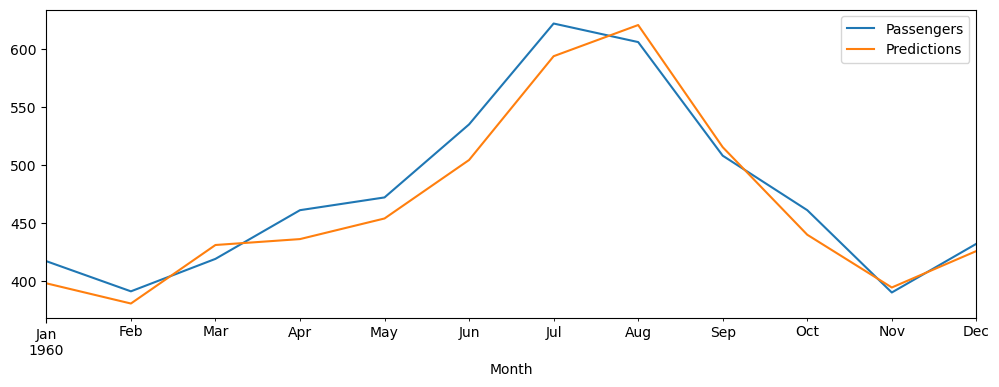

In [39]:
test.plot(figsize=(12,4))

In [40]:
from sklearn.metrics import mean_squared_error 

In [41]:
rmse=np.sqrt(mean_squared_error(test["Passengers"],test["Predictions"]))
rmse

18.44698359965318